<a href="https://colab.research.google.com/github/yoondol/CodeFolder/blob/main/CAD_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

관상동맥질환

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#plotly has been used for visualization
import plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px

import missingno as msno # NaN 값이 있는지 시각적으로 표현해주는 라이브러리입니다.
from scipy import stats


#model
from sklearn.experimental import enable_halving_search_cv
# now you can import normally from model_selection
from sklearn.model_selection import (cross_validate, StratifiedKFold, train_test_split,GridSearchCV,
                                    HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score)
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix



import warnings
warnings.filterwarnings("ignore")    # (Optional)




In [4]:
url = '/content/drive/MyDrive/대외활동/SeSac/heart_2022_with_nans.csv'
df_origin=pd.read_csv(url,sep=',')
df_origin.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [5]:
df_origin.shape

(445132, 40)

In [6]:
df_origin.describe(include='all')

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
count,445132,445132,443934,434205.000000,436065.000000,436824,444039,439679.000000,433772,442067,...,416480.000000,403054.000000,396326.000000,398558,379005,398011,368092,362616,394509,394368
unique,54,2,5,NaN,NaN,4,2,NaN,4,2,...,NaN,NaN,NaN,2,2,2,2,4,2,3
top,Washington,Female,Very good,NaN,NaN,Within past year (anytime less than 12 months ...,Yes,NaN,None of them,No,...,NaN,NaN,NaN,Yes,No,Yes,No,"No, did not receive any tetanus shot in the pa...",No,No
freq,26152,235893,148444,NaN,NaN,350944,337559,NaN,233455,416959,...,NaN,NaN,NaN,210891,249919,209256,215604,121493,377324,270055
mean,NaN,NaN,NaN,4.347919,4.382649,NaN,NaN,7.022983,NaN,NaN,...,1.702691,83.074470,28.529842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,8.688912,8.387475,NaN,NaN,1.502425,NaN,NaN,...,0.107177,21.448173,6.554889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1.000000,NaN,NaN,...,0.910000,22.680000,12.020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,6.000000,NaN,NaN,...,1.630000,68.040000,24.130000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,7.000000,NaN,NaN,...,1.700000,80.740000,27.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,3.000000,5.000000,NaN,NaN,8.000000,NaN,NaN,...,1.780000,95.250000,31.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_origin.dtypes

State                         object
Sex                           object
GeneralHealth                 object
PhysicalHealthDays           float64
MentalHealthDays             float64
LastCheckupTime               object
PhysicalActivities            object
SleepHours                   float64
RemovedTeeth                  object
HadHeartAttack                object
HadAngina                     object
HadStroke                     object
HadAsthma                     object
HadSkinCancer                 object
HadCOPD                       object
HadDepressiveDisorder         object
HadKidneyDisease              object
HadArthritis                  object
HadDiabetes                   object
DeafOrHardOfHearing           object
BlindOrVisionDifficulty       object
DifficultyConcentrating       object
DifficultyWalking             object
DifficultyDressingBathing     object
DifficultyErrands             object
SmokerStatus                  object
ECigaretteUsage               object
C

In [ ]:
# We have 445132 samples.
#The majority of features are categorical.
#BMI is skewed.
#PhysicalHealth and MentalHealth are severly skewed due to the number of zeros.
#SleepTime is normally distributed.
#There is a severe class imbalance (heart disease vs healthy)
#Alcohol drinking is imbalanced.
#Sroke is imbalanced.
#DiffWalking is imbalanced.
#Age is categorical (divided into bins).
#Race is imbalanced, with the majority being white.
#Diabetic is imbalanced.
#PhysicalActivity is imbalanced
#Asthma is imbalanced
#KidneyDisease is imbalanced
#SkinCancer is imbalanced

In [8]:
df_origin['AgeCategory'].value_counts()

AgeCategory
Age 65 to 69       47099
Age 60 to 64       44511
Age 70 to 74       43472
Age 55 to 59       36821
Age 80 or older    36251
Age 50 to 54       33644
Age 75 to 79       32518
Age 40 to 44       29942
Age 45 to 49       28531
Age 35 to 39       28526
Age 18 to 24       26941
Age 30 to 34       25807
Age 25 to 29       21990
Name: count, dtype: int64

In [9]:
df=df_origin.copy()

In [10]:
# Removing Missing Value

df.isna().sum().sort_values(ascending = False)
# 44만개에서 24만개

TetanusLast10Tdap            82516
PneumoVaxEver                77040
HIVTesting                   66127
ChestScan                    56046
CovidPos                     50764
HighRiskLastYear             50623
BMI                          48806
FluVaxLast12                 47121
AlcoholDrinkers              46574
WeightInKilograms            42078
ECigaretteUsage              35660
SmokerStatus                 35462
HeightInMeters               28652
DifficultyErrands            25656
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
BlindOrVisionDifficulty      21564
DeafOrHardOfHearing          20647
RaceEthnicityCategory        14057
RemovedTeeth                 11360
PhysicalHealthDays           10927
AgeCategory                   9079
MentalHealthDays              9067
LastCheckupTime               8308
SleepHours                    5453
HadAngina                     4405
HadSkinCancer                 3143
HadHeartAttack      

In [11]:
# NaN 값을 포함한 모든 행 제거
df_cleaned = df.dropna()

print("NaN 값을 포함한 행 제거 후 데이터프레임:")
print(df_cleaned)
print("\n원본 데이터프레임의 shape:", df.shape)
print("결측치 제거 후 데이터프레임의 shape:", df_cleaned.shape)
df = df_cleaned

NaN 값을 포함한 행 제거 후 데이터프레임:
                 State     Sex GeneralHealth  PhysicalHealthDays  \
342            Alabama  Female     Very good                 4.0   
343            Alabama    Male     Very good                 0.0   
345            Alabama    Male     Very good                 0.0   
346            Alabama  Female          Fair                 5.0   
347            Alabama  Female          Good                 3.0   
...                ...     ...           ...                 ...   
445117  Virgin Islands    Male     Very good                 0.0   
445123  Virgin Islands  Female          Fair                 0.0   
445124  Virgin Islands    Male          Good                 0.0   
445128  Virgin Islands  Female     Excellent                 2.0   
445130  Virgin Islands    Male     Very good                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
342                  0.0  Within past year (anytime less than 12 months ...   

In [12]:
# Encoding columns
replacement_dict = {'Yes': 1, 'No': 0}
df['HadHeartAttack'] = df['HadHeartAttack'].replace(replacement_dict).astype(int)
df['HadAngina'] = df['HadAngina'].replace(replacement_dict).astype(int)


In [13]:

# Create a new column that will be our target column
df['CAD'] = df['HadHeartAttack'] | df['HadAngina']

# Drop old columns
df.drop(columns = ['HadHeartAttack','HadAngina'], inplace = True)

df.shape
df['CAD']

342       0
343       0
345       0
346       0
347       0
         ..
445117    0
445123    0
445124    0
445128    0
445130    1
Name: CAD, Length: 246022, dtype: int64

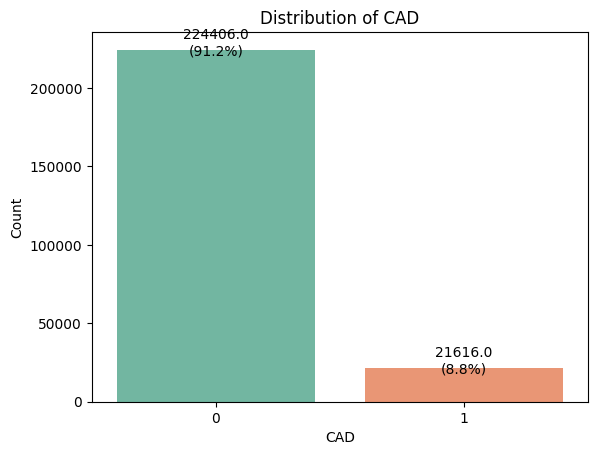

In [17]:
ax = sns.countplot(x='CAD', data=df, palette='Set2')

# Add titles and labels
plt.title('Distribution of CAD')
plt.xlabel('CAD')
plt.ylabel('Count')

# Calculate the total number of samples
total = len(df)

# Annotate each bar with the count and proportion
for p in ax.patches:
    count = p.get_height()
    proportion = count / total * 100
    ax.annotate(f'{count}\n({proportion:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()

## Numerical columns

In [19]:


df_num = df.select_dtypes(include = ['float64', 'int64'])
print(df_num.shape)
df_num.head()

(246022, 7)


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,CAD
342,4.0,0.0,9.0,1.60,71.67,27.99,0
343,0.0,0.0,6.0,1.78,95.25,30.13,0
345,0.0,0.0,8.0,1.85,108.86,31.66,0
346,5.0,0.0,9.0,1.70,90.72,31.32,0
347,3.0,15.0,5.0,1.55,79.38,33.07,0


In [20]:
df_num.columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'CAD'],
      dtype='object')

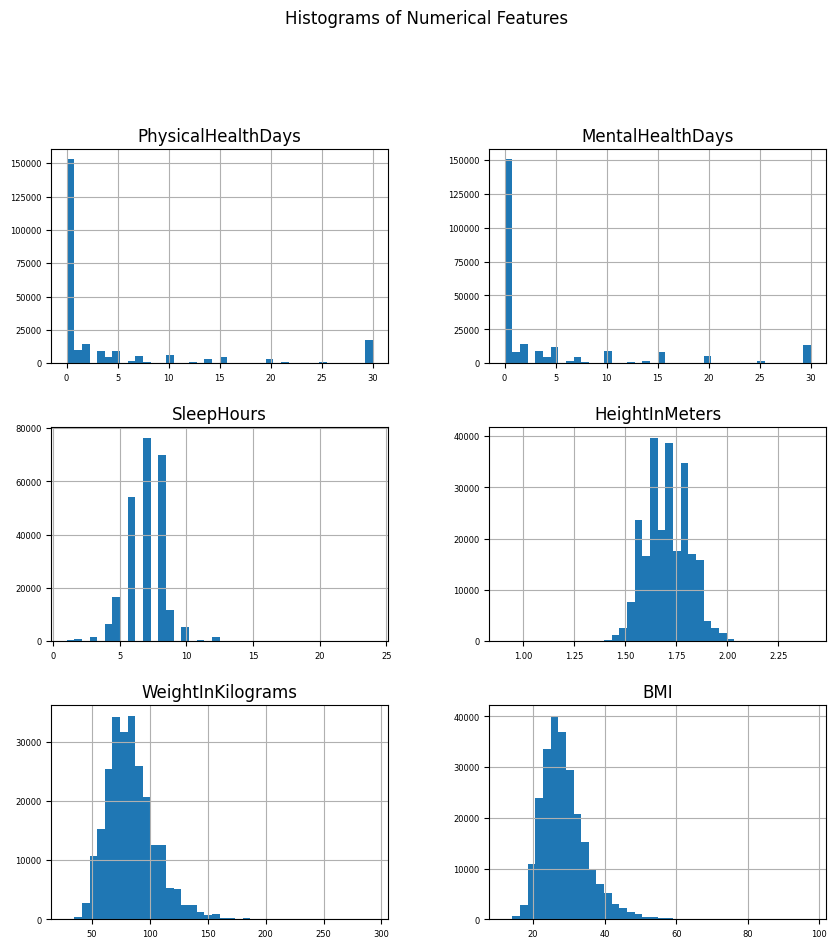

In [31]:
# Plot the distribution for all the numerical features.

# Drop the 'CAD' column from the numerical DataFrame
df_num_excl_cad = df_num.drop(columns=['CAD'])

# Plot histograms for all numerical features excluding 'CAD'
df_num_excl_cad.hist(figsize=(10, 10), bins=40, xlabelsize=6, ylabelsize=6)

# Add a title to the entire figure
plt.suptitle('Histograms of Numerical Features', y=1.02)
plt.show()

In [26]:
# Explore the distribution of numerical features
# 수치형 변수 간의 관계 탐색 (두 변수 간에 선형 관계까 있는지, 비선형 관계가 있는지,
# 또는 전혀 관계가 없는지 등을 시각적으로 파악)
# 각 변수의 히스토그램을 포함하여 데이터의 분포를 시각화
# sns.pairplot(df)
sns.pairplot(df_num, hue='CAD')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7b9a7279b130> (for post_execute):


KeyboardInterrupt: 

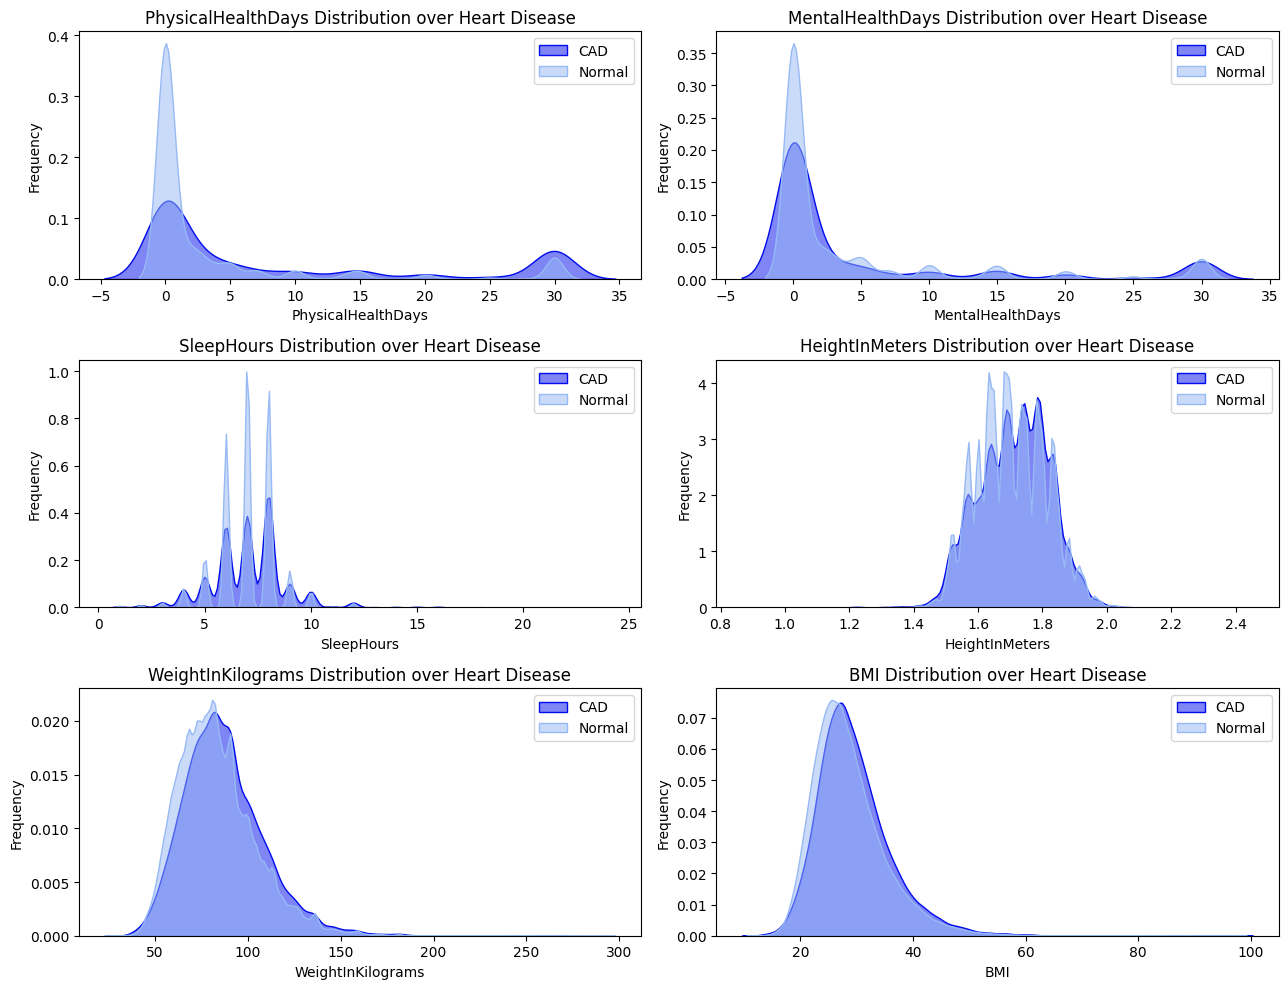

In [25]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(13, 10))

for idx, column in enumerate(df_num.drop(columns = 'CAD')):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.kdeplot(df[df["CAD"] == 1][column], alpha=0.5, fill=True, color="#000CEB", label="CAD", ax=axes[row_idx, col_idx])
    sns.kdeplot(df[df["CAD"] == 0][column], alpha=0.5, fill=True, color="#97B9F4", label="Normal", ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel("Frequency")
    axes[row_idx, col_idx].set_title(f"{column} Distribution over Heart Disease")
    axes[row_idx, col_idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
df_num.columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'CAD'],
      dtype='object')

In [ ]:
df['HadKidneyDisease'].head()

342    No
343    No
345    No
346    No
347    No
Name: HadKidneyDisease, dtype: object

In [ ]:
print(df['CAD'].value_counts())
target_df=df[df.CAD==1]
nontarget_df=df[df.CAD==0]

CAD
0    224406
1     21616
Name: count, dtype: int64


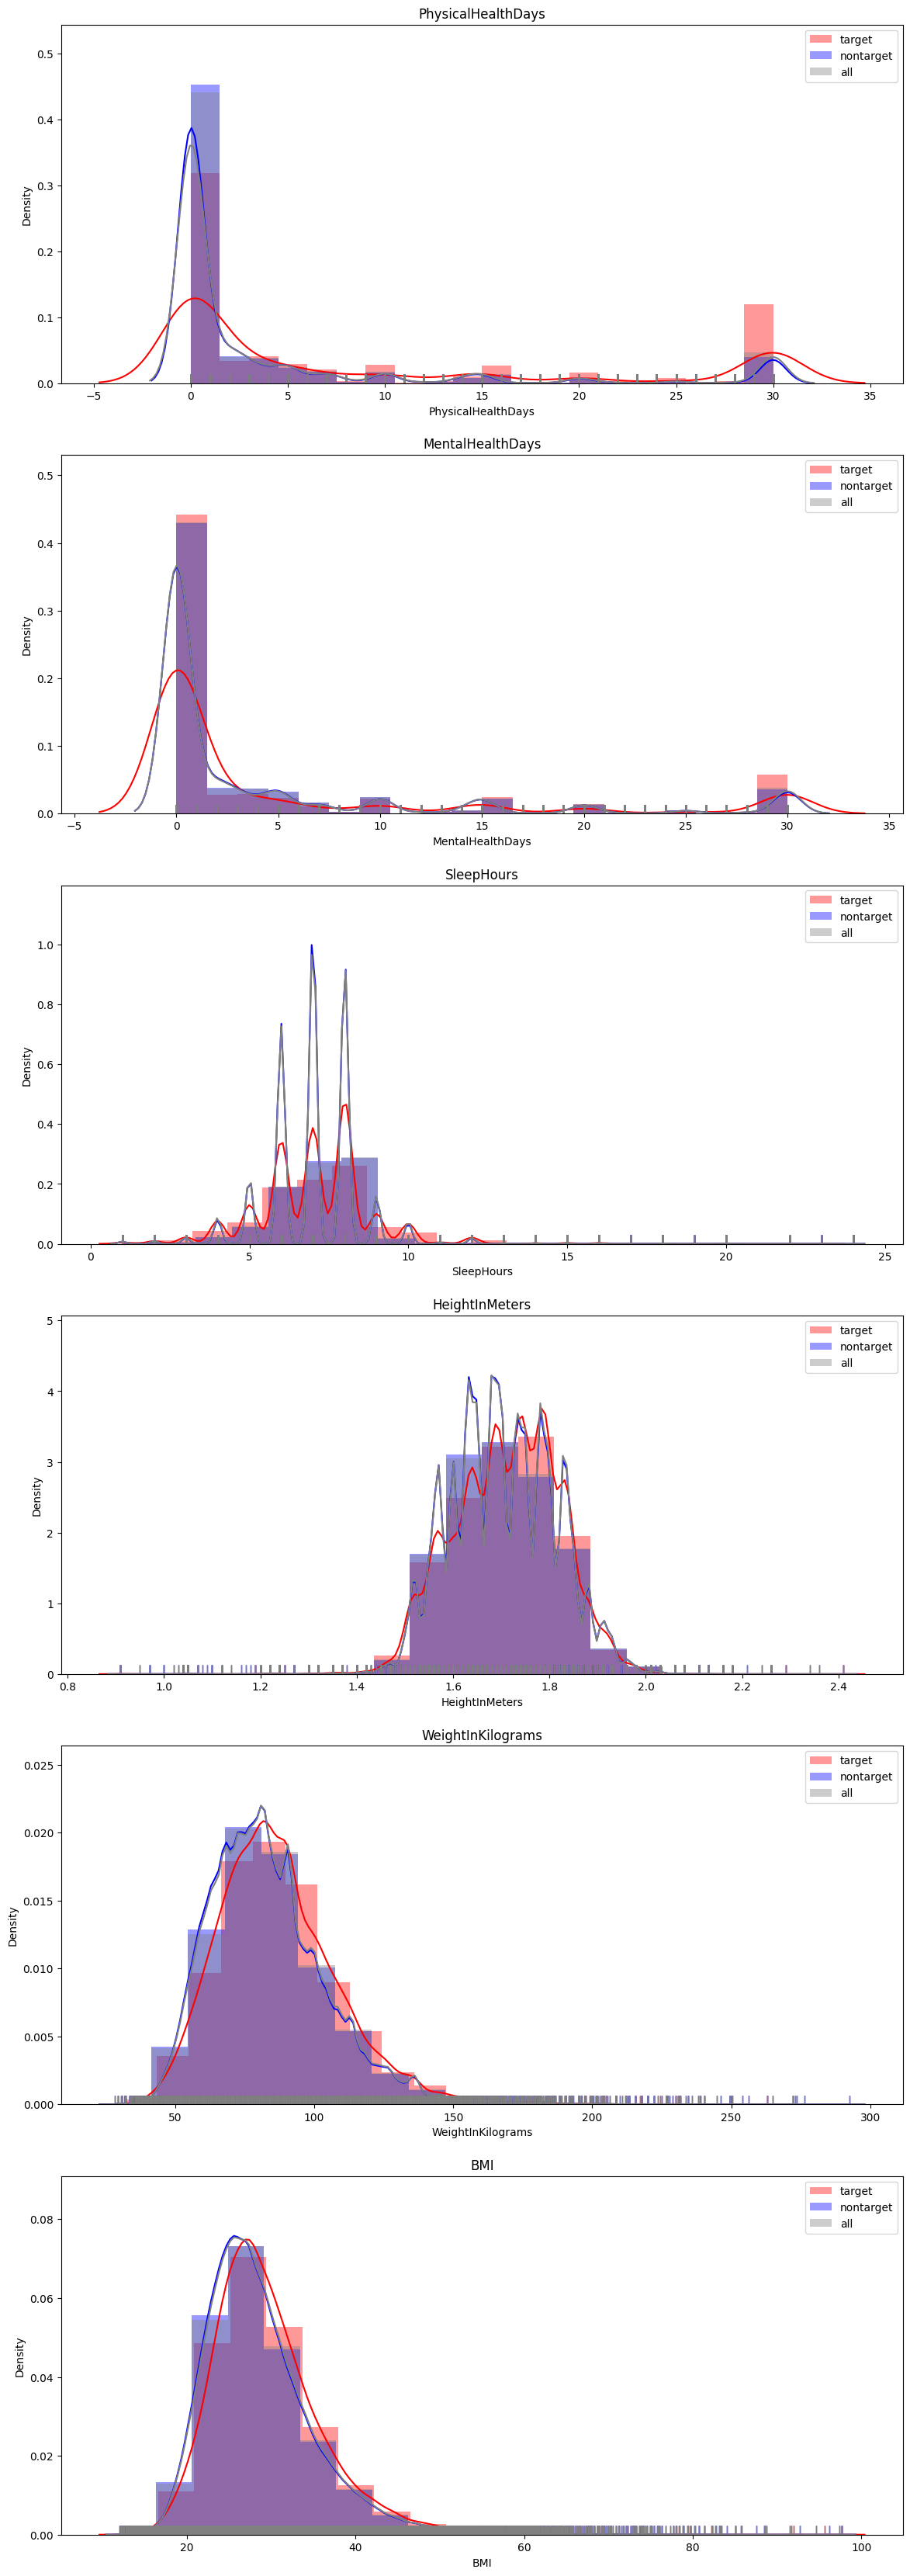

In [ ]:
continually_index = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI']# 연속형 자료
fig,ax=plt.subplots(len(continually_index), 1, figsize = (14,7*len(continually_index)))
list_couint=1
for index in continually_index:
    plt.subplot(len(continually_index),1,list_couint)
    plt.title(index)
    sns.distplot(target_df[index],bins=20, kde=True, rug=True, color='red',label='target')
    sns.distplot(nontarget_df[index],bins=20,kde=True, rug=True,color='blue',label='nontarget')
    sns.distplot(df[index],bins=20,kde=True, rug=True,color='gray',label='all')
    plt.legend()
    list_couint+=1

In [ ]:
colors = [ 'Blue',  'Cyan',"navy",'LightCyan',]
CustomPalette = sns.set_palette(sns.color_palette(colors))

dfcolumns=[ 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos']

plt.subplots_adjust(left=0.3, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.3)

for i, col1 in enumerate(dfcolumns):
    if col1=="Race":
        continue
    else:
    #for j, col2 in enumerate(numericaldf):
        fig , axes= plt.subplots(1,2, figsize=(17,2),gridspec_kw={'width_ratios': [2.25, 1.25]})

        ax=plt.subplot(1,2,1 )
        ax0=sns.distplot(df[col1][df['HeartDisease']=="0"],hist=False, kde=True,label='HeartDisease = No' )
        ax1=sns.distplot(df[col1][df['HeartDisease']=="1"],hist=False, kde=True , ax=ax0, label='HeartDisease= Yes')

        # Get the two lines from the axes to generate shading
        l1 = ax.lines[0]
        l2 = ax.lines[1]

        # Get the xy data from the lines so that we can shade
        x1 = l1.get_xydata()[:,0]
        y1 = l1.get_xydata()[:,1]
        x2 = l2.get_xydata()[:,0]
        y2 = l2.get_xydata()[:,1]
        ax.fill_between(x1,y1, color="blue", alpha=0.3)
        ax.fill_between(x2,y2, color="aqua", alpha=0.3)




        #plt.legend(loc='upper right')


        ax=plt.subplot(1,2,2)
        ax2=sns.histplot(data=df, x=df[col1], hue=df['HeartDisease'], multiple="stack")
        for container in ax.containers:
            if col1=="BMI":
                continue
            elif col1== "PhysicalHealth":
                continue
            elif col1== "MentalHealth":
                continue
            elif col1== "SleepTime":
                continue
            else:
                ax.bar_label(container)



plt.show()

### Outliers

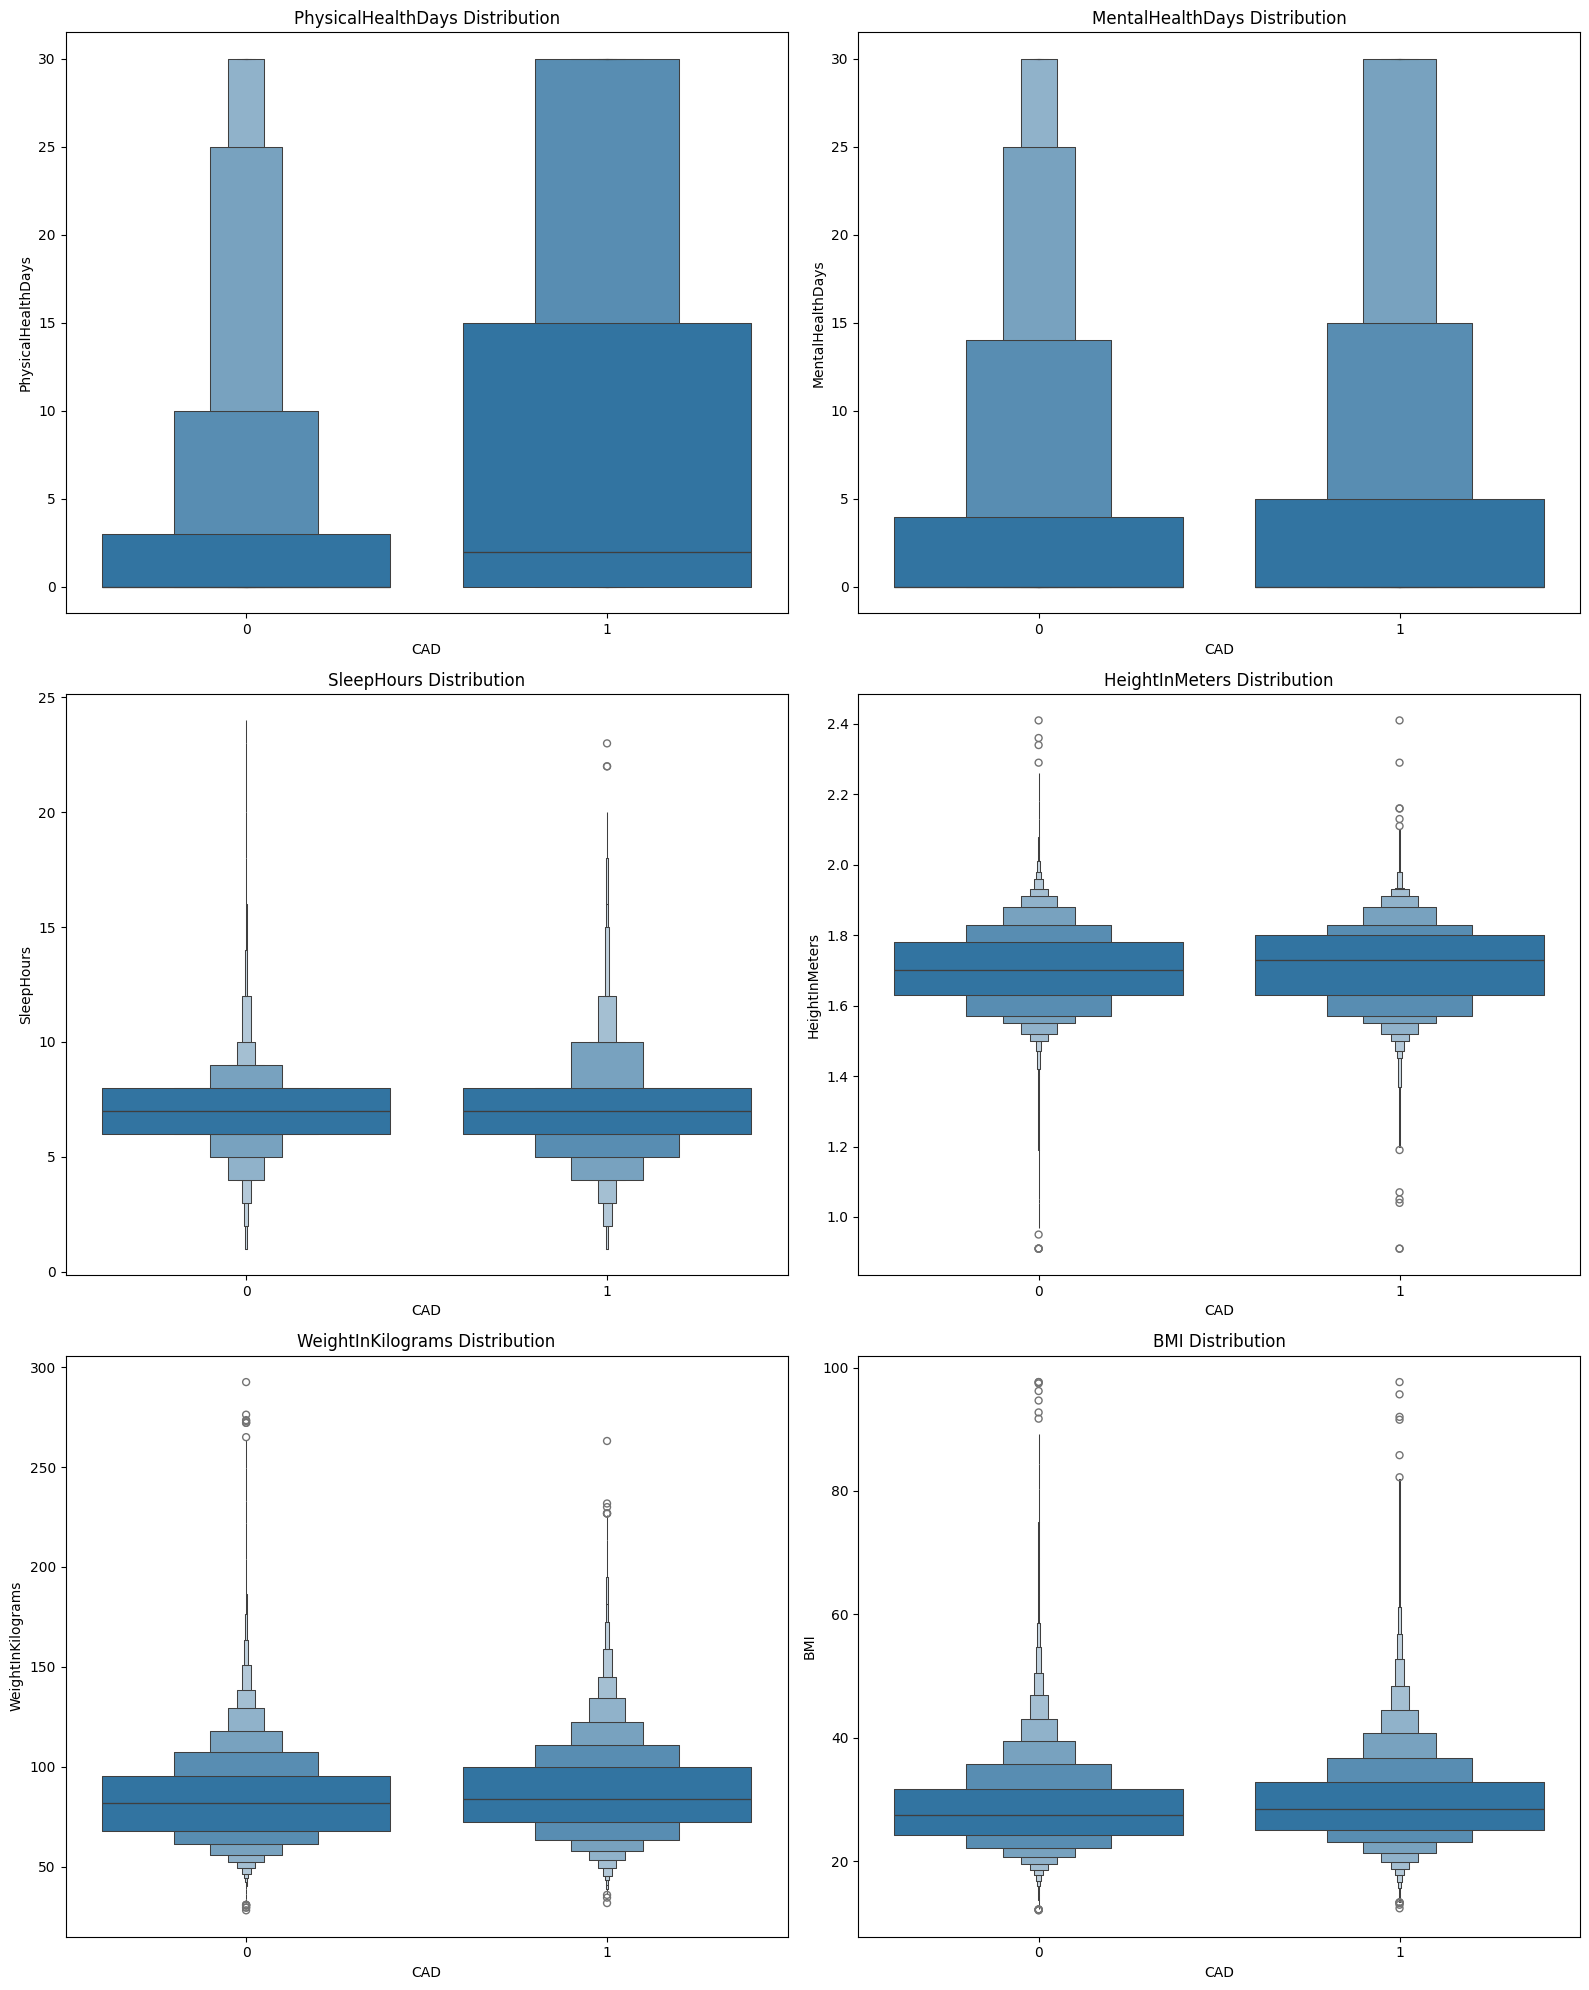

In [ ]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(16, 20))

for idx, column in enumerate(df_num.drop(columns = 'CAD')):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.boxenplot( x='CAD' , y= column , data=df, ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel("CAD")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()

### Multicollinearity (다중공선성) & 상관관계

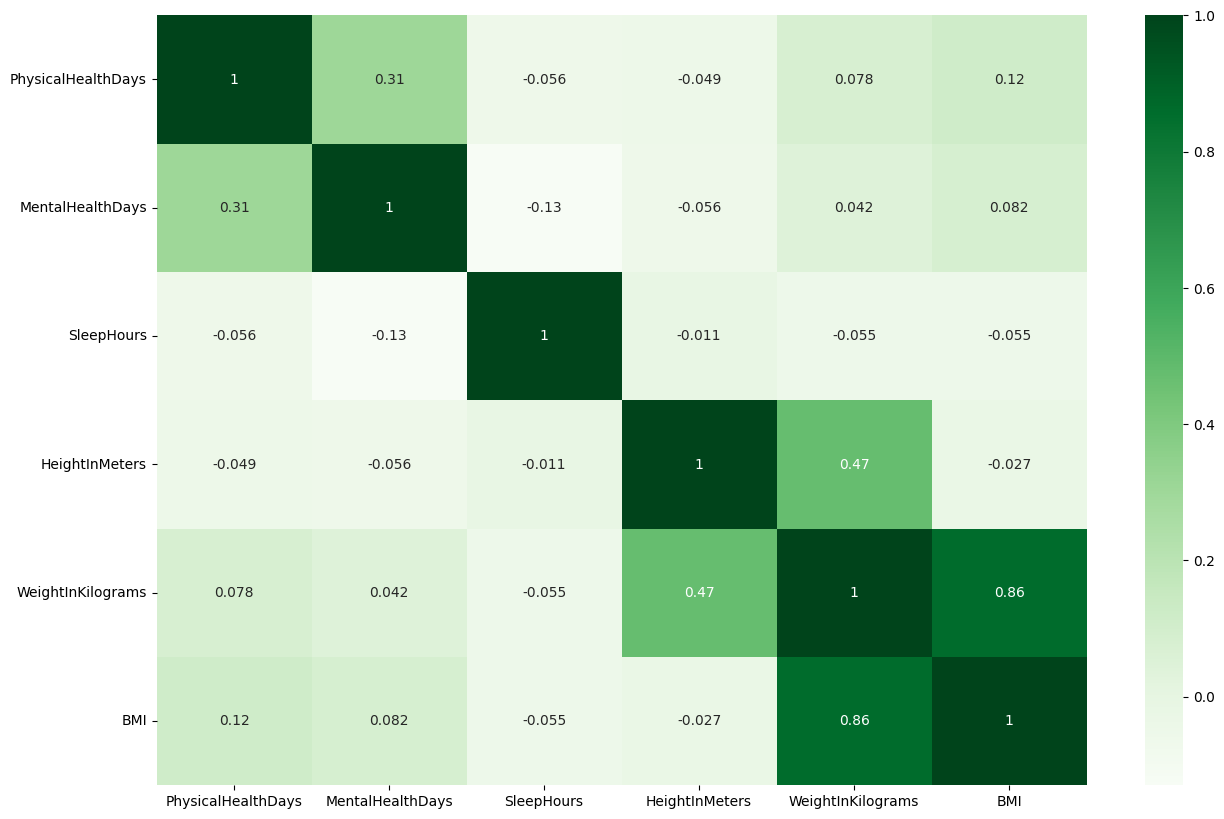

In [ ]:
corr = df_num.drop(columns= 'CAD').corr()
fig , ax = plt.subplots(figsize=(15 , 10))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

In [ ]:
# Now we will search for columns that has a correlation more than 70%
# and drop one of them with the condition that the correlation
# with the target column (HeartDisease) is smaller than another column

# check the correlation for columns => WeightInKilograms & BMI with the target
print(f"Correlation between WeightInKilograms and BMI :{df['WeightInKilograms'].corr(df['BMI'])}")

print(f"Correlation between WeightInKilograms and the target :{df['WeightInKilograms'].corr(df['CAD'])}")

print(f"Correlation between BMI and the target :{df['BMI'].corr(df['CAD'])}")

Correlation between WeightInKilograms and BMI :0.859313232736645
Correlation between WeightInKilograms and the target :0.05038453987386603
Correlation between BMI and the target :0.04500233612614124


In [ ]:
# drop 'WeightInKilograms' column
df.drop(columns = 'WeightInKilograms', inplace = True)

## Categorial Columns

In [ ]:
df_cat = df.select_dtypes('object')
df_cat.nunique().sort_values()

BlindOrVisionDifficulty       2
DifficultyDressingBathing     2
DifficultyWalking             2
DifficultyConcentrating       2
HighRiskLastYear              2
DeafOrHardOfHearing           2
AlcoholDrinkers               2
HadArthritis                  2
HadKidneyDisease              2
DifficultyErrands             2
HadDepressiveDisorder         2
HadSkinCancer                 2
HadAsthma                     2
HadStroke                     2
HIVTesting                    2
PhysicalActivities            2
FluVaxLast12                  2
PneumoVaxEver                 2
Sex                           2
HadCOPD                       2
ChestScan                     2
CovidPos                      3
SmokerStatus                  4
HadDiabetes                   4
RemovedTeeth                  4
LastCheckupTime               4
TetanusLast10Tdap             4
ECigaretteUsage               4
RaceEthnicityCategory         5
GeneralHealth                 5
AgeCategory                  13
State   

### Encoding categorical data

In [ ]:
#this for Dummy calsifier
dfc = df

df_categorical=df_cat.columns
df_categorical

Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadStroke', 'HadAsthma',
       'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
       'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing',
       'BlindOrVisionDifficulty', 'DifficultyConcentrating',
       'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
       'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12',
       'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [ ]:
searchList=[  'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12',
       'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']

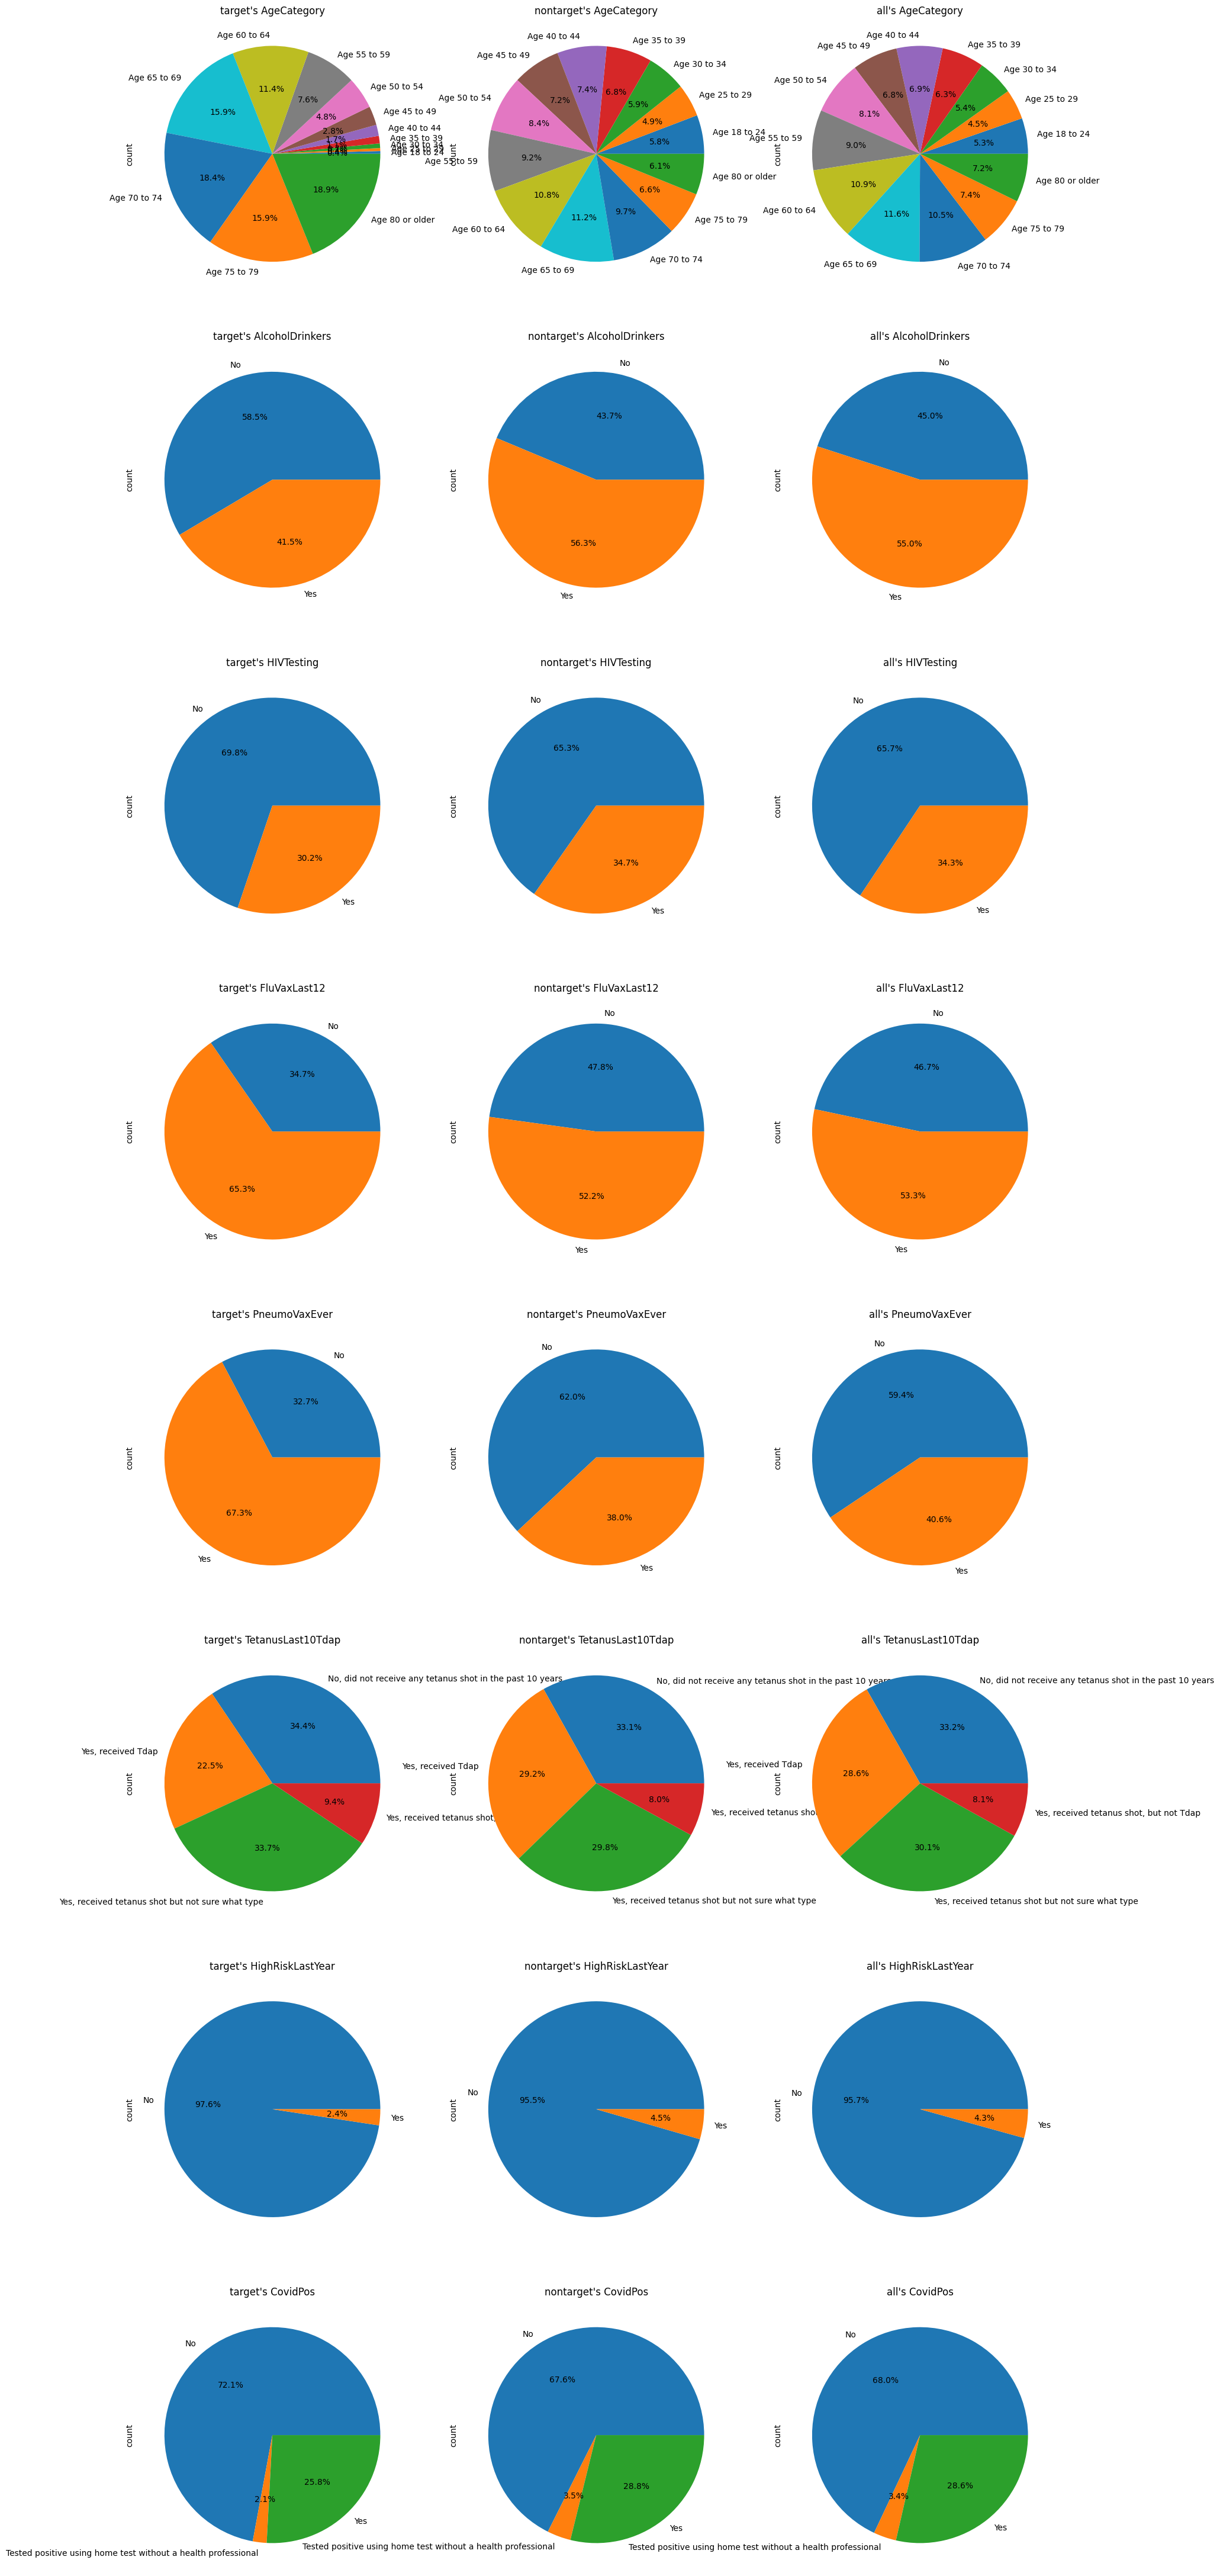

In [ ]:
fig,ax=plt.subplots(len(searchList), 3, figsize = (20,7*len(searchList)))
axnum=1
#explode=[0.02  for x in range(len(heart[index].cat.categories))],
for index in searchList:
    plt.subplot(len(searchList),3,axnum)
    plt.title('target\'s '+index)
    target_df[index].value_counts().sort_index().plot.pie(
                                                      autopct='%0.1f%%')
    axnum+=1

    plt.subplot(len(searchList),3,axnum)
    plt.title('nontarget\'s '+index)
    nontarget_df[index].value_counts().sort_index().plot.pie(
                                                         autopct='%0.1f%%')
    axnum+=1

    plt.subplot(len(searchList),3,axnum)
    plt.title('all\'s '+index)
    df[index].value_counts().sort_index().plot.pie(
                                                  autopct='%0.1f%%')
    axnum+=1

In [ ]:
#stroke asthma skincancer 여러 가지 그래프 쌓아서 서로 비교

In [ ]:
# Converting Valuse of Dataset
# 전처리. 범주형 데이터를 수치화

df['AgeCategory'] = df['AgeCategory'].str[:2]

df['GenHealth']=df['GenHealth'].replace('Poor','0')
df['GenHealth']=df['GenHealth'].replace('Fair','1')
df['GenHealth']=df['GenHealth'].replace('Good','2')
df['GenHealth']=df['GenHealth'].replace('Very good','3')
df['GenHealth']=df['GenHealth'].replace('Excellent','4')

df["Diabetic"]=df['Diabetic'].replace('No, borderline diabetes','3')
df["Diabetic"]=df['Diabetic'].replace('Yes (during pregnancy)','4')

df=df.replace('No','0')
df= df.replace('Yes','1')
df=df.replace('Female','0')
df= df.replace('Male','1')

df

KeyError: 'GenHealth'

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), df_categorical)],
    remainder='passthrough')

X_transformed = preprocessor.fit_transform(df.drop(columns = 'CAD'))

## 데이터 나누기

In [ ]:
# Splitting data for train and test
target = df['CAD']

X_train , X_test , y_train , y_test = train_test_split(X_transformed ,target ,test_size=0.2 , random_state=42 )
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# Target balance
heart_disease_column = df.HeartDisease.value_counts()

# pie chart for target column
plt.pie(heart_disease_column, labels = heart_disease_column.index, autopct="%1.1f%%", explode = [0,0.1], colors = ["#0142F4","#00EBB5"])
plt.title("distribution of CAD")
plt.axis("equal")
plt.show()

# so we can see that data is imbalanced

### Resampling Data

######  The best technique in resampling is to merge between over_sampling and under_sampling Because this means you do not lose a lot of features values that can make your model better and the duplication in over_sampling tries to make a model prediction balanced between target labels.


In [ ]:
df.HeartDisease.value_counts()